# Imports

In [15]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
import PIL

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_location = '/home/marcin/Datasets/udacity-challange-flower-data/flower_data/'

# Convert Images to Dataset (optional)

This section does following:
* reads all images
* optinally auguments train set
* passess all images through conv layers of pretrained net
* saves extracted features to file
* resulting file contains:
  * optionally augumented and extended train set - features & labels
  * untoutched valid set - features & labels
  
You need to re-run this section only if:
* you want to change agumentations
* you want to change pretrained network

In [22]:
# Option 'v2'
transforms_list = transforms.Compose([
    transforms.Resize(256),
    transforms.Pad(100, padding_mode='reflect'),
    #transforms.RandomRotation(45),
    transforms.RandomAffine(degrees=45, translate=(.1, .1), shear=20, resample=PIL.Image.BILINEAR),
    transforms.CenterCrop(256),
    transforms.RandomResizedCrop(224, scale=(0.7 , 1.3)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.1, contrast=.1, saturation=.1, hue=.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])


# # Option 'v1'
# transforms_list = transforms.Compose([
#     transforms.Resize(256),
#     transforms.Pad(100, padding_mode='reflect'),
#     transforms.RandomRotation(45),
#     transforms.CenterCrop(256),
#     transforms.RandomResizedCrop(224, scale=(0.8 , 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], 
#                          [0.229, 0.224, 0.225])
# ])

# # Opton 'Standard'
# transforms_list = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], 
#                          [0.229, 0.224, 0.225])
# ])

In [23]:
dataset_train = datasets.ImageFolder(os.path.join(dataset_location, 'train'), transforms_list)
dataset_valid = datasets.ImageFolder(os.path.join(dataset_location, 'valid'), transforms_list)
print('Number of train images:', len(dataset_train))
print('Number of valid images:', len(dataset_valid))

Number of train images: 6552
Number of valid images: 818


In [29]:
enable_shuffle = True
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=enable_shuffle,
                                               num_workers=6, pin_memory=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=16, shuffle=enable_shuffle,
                                               num_workers=6, pin_memory=True)

**Test Augumentations**

**Note:** you need to disable dataloader shuffle for this section to work

In [25]:
images, labels = iter(dataloader_train).next()

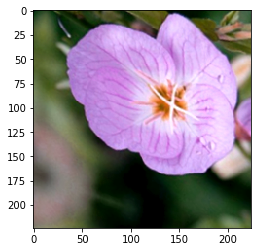

In [26]:
def show_tensor(ax, img_tensor):
    ttt = np.array(img_tensor.permute(2, 1, 0))
    ttt = ttt * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # undo normalization
    ax.imshow( np.array(ttt*255, dtype=int) )

fig, ax = plt.subplots()    
show_tensor(ax, images[0])

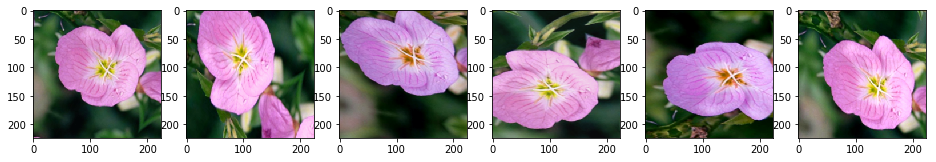

In [27]:
fig, axes = plt.subplots(ncols=6, figsize=[16,6])
for ax in axes:
    images, labels = iter(dataloader_train).next()
    show_tensor(ax, images[0])

# Precompute Features

In [30]:
assert enable_shuffle == True

In [31]:
class Passthrough(torch.nn.Module):
    def forward(self, input):
        return input

In [32]:
#model_cnn = models.densenet121(pretrained=True)
#model_cnn = models.resnet50(pretrained=True)
#model_cnn = models.resnet152(pretrained=True)
#model_cnn = models.inception_v3(pretrained=True)
model_cnn = models.densenet201(pretrained=True)

# disable all gradients
for param in model_cnn.parameters():
    param.requires_grad = False

model_cnn.classifier = Passthrough()
model_cnn.to(device);

/home/marcin/.anaconda/envs/ptgpu/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [33]:
def extract_features(model_cnn, dataloader, num_epochs=1):
    """
    Params:
        model_cnn - big convnet with final dense layers removed
        dataloader - we get data from here
    """
    features_list = []
    labels_list = []
    
    model_cnn.eval()
    for epoch in range(num_epochs):
        print(f'Processing epoch: {epoch:3d}', end='')
        time_start = time.time()
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model_cnn(images)
            features_list.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())
        time_interval = time.time() - time_start
        print(f'    fime: {time_interval:5.2f}')

    features_arr = np.concatenate(features_list)
    labels_arr = np.concatenate(labels_list)

    return features_arr, labels_arr

In [34]:
train_features, train_labels = extract_features(model_cnn, dataloader_train, num_epochs=10)

Processing epoch:   0    fime: 32.56
Processing epoch:   1    fime: 33.43
Processing epoch:   2    fime: 33.63
Processing epoch:   3    fime: 34.00
Processing epoch:   4    fime: 33.34
Processing epoch:   5    fime: 33.80
Processing epoch:   6    fime: 32.80
Processing epoch:   7    fime: 32.55
Processing epoch:   8    fime: 32.68
Processing epoch:   9    fime: 32.64


In [35]:
print('Shape of train features (inputs):', train_features.shape)
print('Shape of train labels (targets): ', train_labels.shape)
print('Type of train feat. and labels:  ', train_features.dtype, train_labels.dtype)
print('Sample of labels:', train_labels[:20])

Shape of train features (inputs): (65520, 1920)
Shape of train labels (targets):  (65520,)
Type of train feat. and labels:   float32 int64
Sample of labels: [52 81 66 60 76 11 96 43 15 87  5  9 22 44 49 94 98 43 77 15]


In [36]:
valid_features, valid_labels = extract_features(model_cnn, dataloader_valid)

Processing epoch:   0    fime:  4.76


In [37]:
print('Shape of validation features (inputs):', valid_features.shape)
print('Shape of validation labels (targets): ', valid_labels.shape)
print('Type of valid. features and labels:   ', valid_features.dtype, valid_labels.dtype)
print('Sample of labels:', valid_labels[:20])

Shape of validation features (inputs): (818, 1920)
Shape of validation labels (targets):  (818,)
Type of valid. features and labels:    float32 int64
Sample of labels: [52 84 70 49 76 88 40 59 44 77 31 71 60 97 21 41 18 62 64 98]


**Save Checkpoint**

In [41]:
dataset_npz = os.path.join(dataset_location, 'dataset_densenet201_augv2.npz')
dataset_npz

'/home/marcin/Datasets/udacity-challange-flower-data/flower_data/dataset_densenet201_augv2.npz'

In [42]:
#uncomment if you realy want to save, will override existing
# np.savez(dataset_npz,
#          train_features=train_features,
#          train_labels=train_labels,
#          valid_features=valid_features,
#          valid_labels=valid_labels)

# Train Model

**Load Dataset**

In [4]:
dataset_npz = os.path.join(dataset_location, 'dataset_densenet201_augv2.npz')
dataset_npz

'/home/marcin/Datasets/udacity-challange-flower-data/flower_data/dataset_densenet201_augmented.npz'

In [5]:
npzfile = np.load(dataset_npz)
train_features = npzfile['train_features']
train_labels = npzfile['train_labels']
valid_features = npzfile['valid_features']
valid_labels = npzfile['valid_labels']

In [6]:
print('Shape of train features (inputs):', train_features.shape)
print('Shape of train labels (targets): ', train_labels.shape)
print('Type of train feat. and labels:  ', train_features.dtype, train_labels.dtype)
print('Sample of labels:', train_labels[:20])

Shape of train features (inputs): (65520, 1920)
Shape of train labels (targets):  (65520,)
Type of train feat. and labels:   float32 int64
Sample of labels: [44 10 65 20 16 35 79 33 52 63 54 90 20 50 57 57 85 96 43 45]


In [7]:
print('Shape of validation features (inputs):', valid_features.shape)
print('Shape of validation labels (targets): ', valid_labels.shape)
print('Type of valid. features and labels:   ', valid_features.dtype, valid_labels.dtype)
print('Sample of labels:', valid_labels[:20])

Shape of validation features (inputs): (818, 1920)
Shape of validation labels (targets):  (818,)
Type of valid. features and labels:    float32 int64
Sample of labels: [ 30  24  78  53  97  57  40  65  86  28   5  82 101   2  42  75  40  59
  36  38]


Load dataset to GPU

In [43]:
x_train = torch.tensor(train_features).to(device)
y_train = torch.tensor(train_labels).to(device)
x_valid = torch.tensor(valid_features).to(device)
y_valid = torch.tensor(valid_labels).to(device)

**Define Model**

In [54]:
model = nn.Sequential(OrderedDict([
    #('bn1', nn.BatchNorm1d(1920)),
    ('fc1', nn.Linear(1920, 512)),
    ('elu1', nn.ELU()),
    ('drp1', nn.Dropout(0.75)),
    
#     ('fc2', nn.Linear(512, 512)),
#     ('elu2', nn.ELU()),
#     ('drp2', nn.Dropout(0.9)),
    
    ('fcf', nn.Linear(512, 102)),
]))
model.to(device)

criterion = nn.CrossEntropyLoss() # nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00003)
#scheduler = torch.optim.lr_scheduler()

hist = { 'tloss':[], 'tacc':[],    # mini-batch loss/acc every iteration
         'train_loss':[], 'train_acc':[],       # train set loss/acc every epoch
         'valid_loss':[], 'valid_acc':[] }      # valid set loss/acc every epoch

Helper

In [55]:
def accuracy(logits, labels): 
    predictions = torch.argmax(logits, dim=1)
    return (predictions == labels).float().mean()  # tensor!!

Train model

In [57]:
num_epochs = 30
batch_size = 128

train_size = len(x_train)

train_start_time = time.time()

for epoch in range(num_epochs):
    
    epoch_time_start = time.time()
    
    ### Train ###
    model.train()
    indices = torch.randperm(len(x_train), device=device)          # indices = [2423, 1563, 4854, ...]
    for i in range(0, len(x_train), batch_size):                   # i = 0, batch_size, 2*batch_size, ...
        
        # Pick mini-batch
        x = x_train[indices[i:i+batch_size]]
        y = y_train[indices[i:i+batch_size]]
        
        # Optimize
        optimizer.zero_grad()
        outputs = model(x)                                         # logits
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        # Record per-iteration stats
        with torch.no_grad():
            acc = accuracy(outputs, y)
            hist['tacc'].append( acc.item() )
            hist['tloss'].append( loss.item() )
            
    ### Evaluate ###
    model.eval()
    with torch.no_grad():
        
        # Eval on train set
        outputs = model(x_train)                                   # pass-in whole train dataset at once
        loss = criterion(outputs, y_train)
        acc = accuracy(outputs, y_train)
        hist['train_acc'].append( acc.item() )
        hist['train_loss'].append( loss.item() )
        
        # Eval on valid set
        outputs = model(x_valid)
        loss = criterion(outputs, y_valid)
        acc = accuracy(outputs, y_valid)
        hist['valid_acc'].append( acc.item() )
        hist['valid_loss'].append( loss.item() )
        
    epoch_time_interval = time.time() - epoch_time_start
    
    ### Print Summary ###
    if epoch == 0:
        print('      (time )   ep             loss / acc                loss / acc')
    print(f'Epoch ({epoch_time_interval:4.2}s): {epoch:3}'
          f'    Train: {hist["train_loss"][-1]:6.4f} / {hist["train_acc"][-1]:6.4f}'
          f'    Valid: {hist["valid_loss"][-1]:6.4f} / {hist["valid_acc"][-1]:6.4f}')

print()
total_train_time = time.time() - train_start_time
print(f'Total train time {total_train_time:6.2f}s')

      (time )   ep             loss / acc                loss / acc
Epoch ( 1.1s):   0    Train: 0.0208 / 0.9974    Valid: 0.2334 / 0.9401
Epoch ( 1.1s):   1    Train: 0.0202 / 0.9975    Valid: 0.2350 / 0.9438
Epoch ( 1.1s):   2    Train: 0.0183 / 0.9978    Valid: 0.2384 / 0.9377
Epoch ( 1.1s):   3    Train: 0.0173 / 0.9979    Valid: 0.2361 / 0.9413
Epoch ( 1.1s):   4    Train: 0.0159 / 0.9984    Valid: 0.2325 / 0.9438
Epoch ( 1.1s):   5    Train: 0.0150 / 0.9984    Valid: 0.2321 / 0.9425
Epoch ( 1.1s):   6    Train: 0.0144 / 0.9985    Valid: 0.2330 / 0.9401
Epoch ( 1.1s):   7    Train: 0.0138 / 0.9986    Valid: 0.2292 / 0.9425
Epoch ( 1.1s):   8    Train: 0.0129 / 0.9987    Valid: 0.2309 / 0.9425
Epoch ( 1.1s):   9    Train: 0.0125 / 0.9988    Valid: 0.2386 / 0.9438
Epoch ( 1.1s):  10    Train: 0.0117 / 0.9990    Valid: 0.2321 / 0.9474
Epoch ( 1.0s):  11    Train: 0.0109 / 0.9990    Valid: 0.2362 / 0.9450
Epoch ( 1.1s):  12    Train: 0.0102 / 0.9991    Valid: 0.2394 / 0.9389
Epoch ( 1

In [131]:
def pretty_plot(ax, data, label, color, alpha):
    def smooth(y, n):
        return np.convolve(y, v=np.ones(n)/n, mode='same')
    #ax.scatter(range(len(data)), data, marker='.', s=1, color=color, alpha=alpha/5)
    ax.plot(smooth(data, 55), label=label, color=color, alpha=alpha)

In [86]:
def plot_hist(hist, title):
    fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,3])
     
    fig.suptitle(title, fontsize=16)
    
    #ax.plot(hist['train_loss'], label='train_loss', color='blue')
    pretty_plot(ax.twiny(), hist['tloss'], 'tloss', color='blue', alpha=.5)
    ax.plot(hist['valid_loss'], label='valid_loss', color='orange')
    ax.set_title('Loss'); ax.legend(); ax.grid(); ax.set_ylim([0, 1]);
    
    #fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,3])
    ax2.plot(hist['train_acc'], label='train_acc', color='blue')
    #pretty_plot(ax2.twiny(), hist['tacc'], 'tacc', color='blue', alpha=1)
    ax2.plot(hist['valid_acc'], label='valid_acc', color='orange')
    ax2.set_title('Accuracy'); ax2.legend(); ax2.grid(); ax2.set_ylim([.8, 1]);
    
    plt.tight_layout()

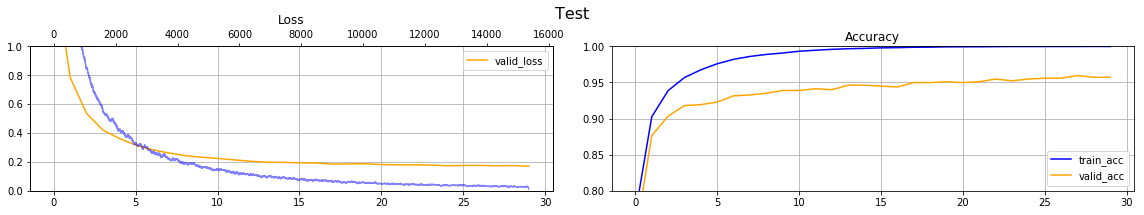

In [123]:
plot_hist(hist, title='Test')

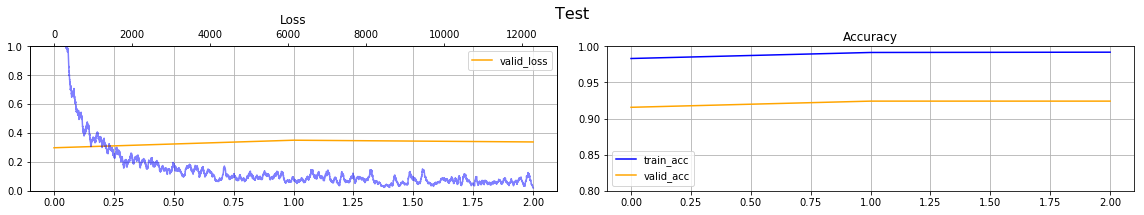

In [14]:
plot_hist(hist, title='Test')

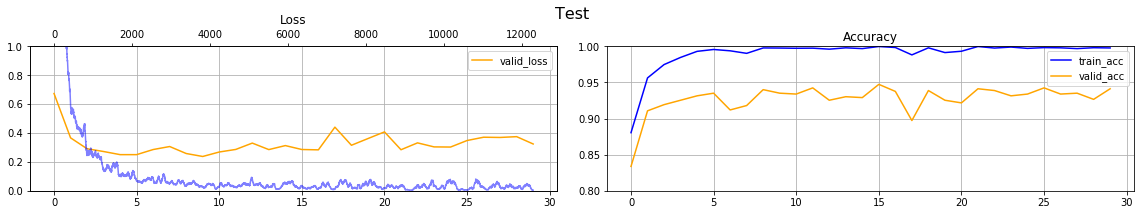

In [21]:
plot_hist(hist, title='Test')

# Results

Param in_features was set to match CNN output size.

In [26]:
print(model)

Sequential(
  (fc1): Linear(in_features=1000, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
)


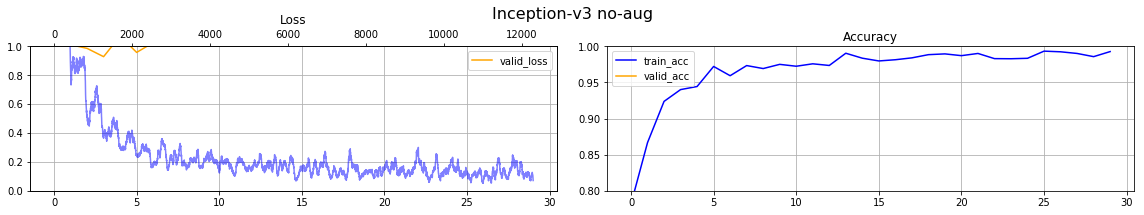

In [51]:
plot_hist(hist, title='Inception-v3 no-aug')

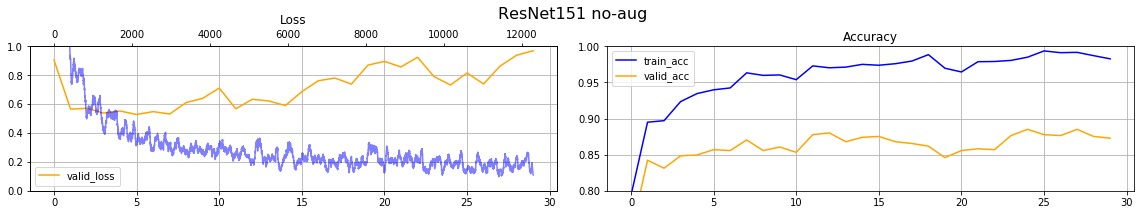

In [38]:
plot_hist(hist, title='ResNet151 no-aug')

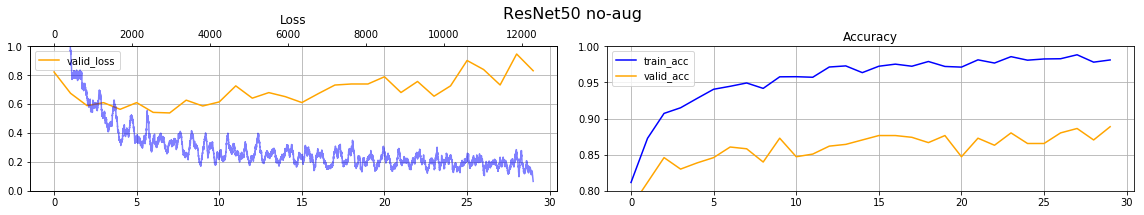

In [27]:
plot_hist(hist, title='ResNet50 no-aug')

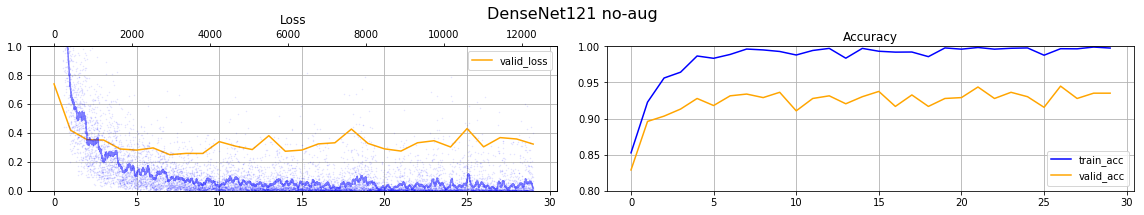

In [167]:
plot_hist(hist, title='DenseNet121 no-aug')

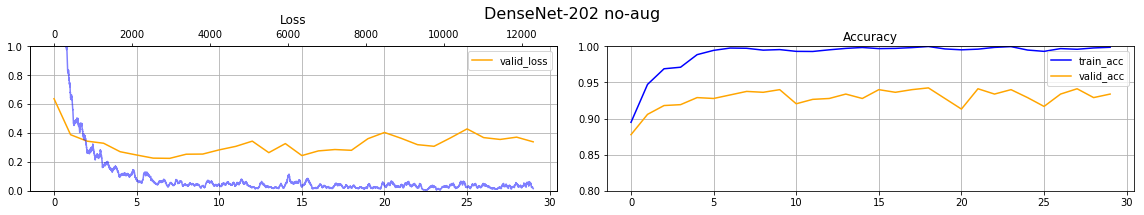

In [64]:
plot_hist(hist, title='DenseNet-202 no-aug')